## Timeseries forecasting with LSTMs

### Example: predict stock price 

### Read data


In [32]:
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet import gluon
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

df = pd.read_csv('data/AMZN.csv')

In [33]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-05-24,64.31250,64.68750,58.0000,58.75000,58.75000,14253800
1,1999-05-25,58.62500,60.56250,55.6875,55.78125,55.78125,15510200
2,1999-05-26,56.59375,60.93750,52.2500,60.46875,60.46875,21158600
3,1999-05-27,59.81250,60.28125,57.0000,57.28125,57.28125,13573400
4,1999-05-28,57.81250,60.18750,56.0000,59.37500,59.37500,9680200


### Plot data

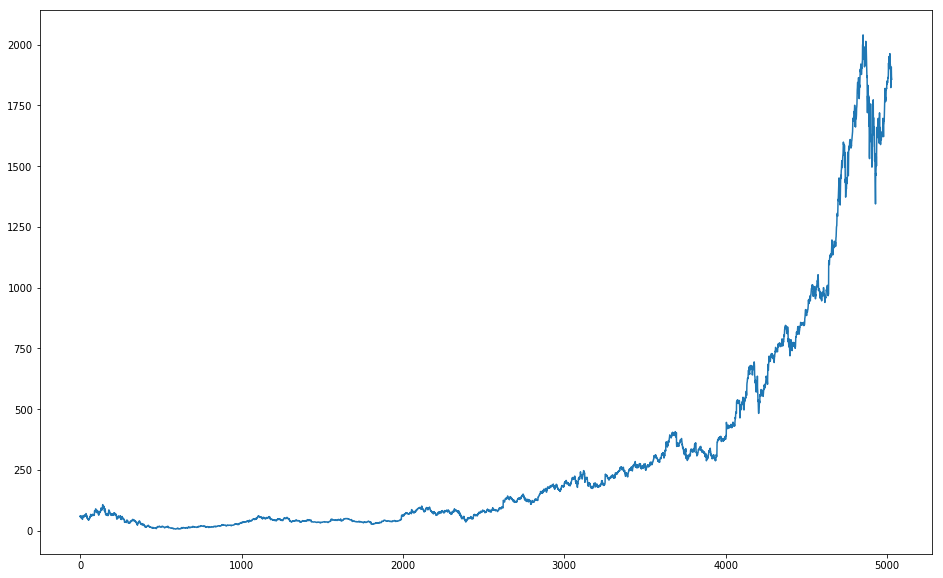

In [34]:
plt.figure(figsize=(16,10))
plt.plot(df['Close'])

### Data normalization

Min-Max Normalization:

<div align="center"> $ y = \frac{x-x_{min}}{x_{max} - x_{min}}$ </div>   



<div align="center"> Disadvantages of Min-Max normalization? </div>   

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = df[['Close']].values

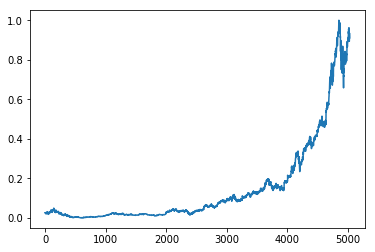

In [36]:
plt.plot(scaler.fit_transform(data.reshape(-1,1)))

### Data normalization

Standardize:

<div align="center"> $ y = \frac{x-\bar{x}} {\sigma}$  </div>
where 
<div align="center">  $ \sigma = \frac{ \sqrt {  \sum (x - \bar{x})^2}}{count(x)} $ </div>

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = df[['Close']].values

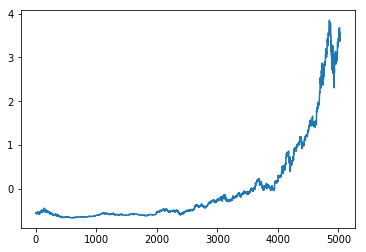

In [38]:
plt.plot(scaler.fit_transform(data.reshape(-1,1)))


<div align="center"> Disadvantages of Standardization? </div> 

### Window normalization
- Input: non-stationary time series
- Create sequences
- Normalize sequences:

<div align="center"> $x_i = \frac{x_i}{x_0} - 1$  </div>


![](data/timeseries.gif)

In [39]:
def create_normalized_data(data, sequence_length):
    
    # number of time series values
    n_samples = data.shape[0]  
    
    # create empty matrices n_samples x sequence_length x 1
    x = np.zeros((n_samples - sequence_length, sequence_length - 1, 1), dtype=np.float32)
    y = np.zeros((n_samples - sequence_length, 1), dtype=np.float32)
    
    # create normalized sequences
    for i in range(0, n_samples - sequence_length): 
        
        # get window
        window = data[i : i + sequence_length,:] 
        
        # normalize
        normalized = [((float(p) / float(window[0])) - 1) for p in window[:]]    
        
        # assign 
        x[i,:,0]   = normalized[:-1]
        y[i,0]     = normalized[-1]
        
    return x, y

### Define Dataloader

In [40]:
num_epochs=5
batch_size=128
ctx = mx.cpu()

# split train/test
n = int(data.shape[0] * 0.85)

# how many past time steps to consider
sequence_length = 20

# get normalized train and test dataset 
x_train, y_train = create_normalized_data(data[:n,:], sequence_length)
x_test, y_test   = create_normalized_data(data[n:,:], sequence_length)

# create Dataloader
dataset = gluon.data.ArrayDataset(x_train, y_train)
train_dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch="rollover", shuffle=True)

### Plot normalized data

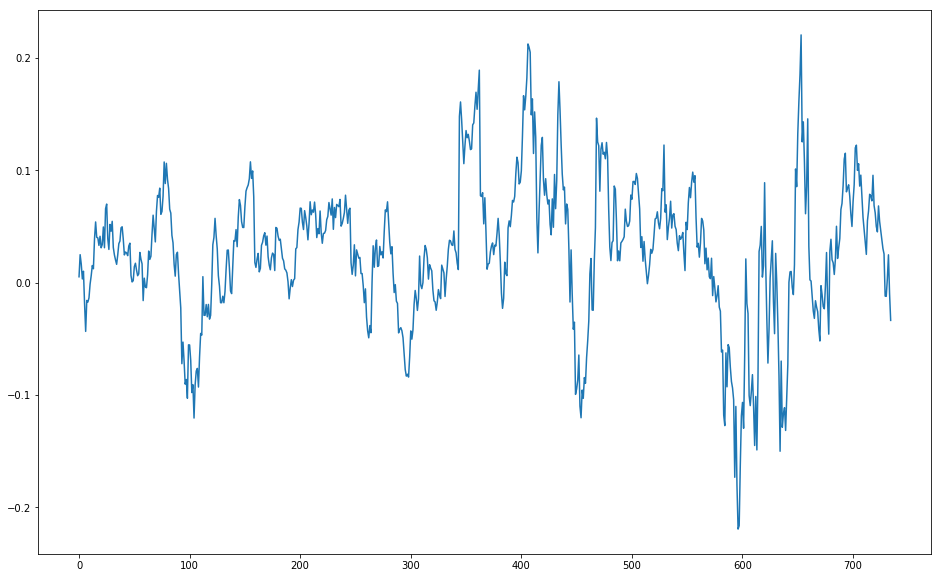

In [41]:
plt.figure(figsize=(16,10))
plt.plot(y_test)

## Simple baseline - persistence model

Take current price at timestep $t_0$ as prediction for next timesteps



Evaluation:
- R2 score: coefficient of determination

<div align="center"> 
$R^2 = 1 - \frac{\sum e^2}{\sum(y_i-\bar y )^2}$
where $e_i = y_i - f_i$
  </div>

In [42]:
from sklearn import metrics

# 1 Timesteps
predictions = y_test[1:-1]
     

In [43]:
baseline = metrics.r2_score(predictions, y_test[0:-2])
print("R2 Score:", baseline)

R2 Score: 0.8478560562075556


## Simple baseline - persistence model

Take current price at timestep $t_0$ as prediction for next 25 timesteps

In [44]:
# 25 Timesteps
predictions = np.zeros((y_test.shape[0]))
for i in range(0,y_test.shape[0],25):
    predictions[i:i+25] = y_test[i]


In [45]:
baseline25 = metrics.r2_score(predictions, y_test)    
print("R2 Score:", baseline25)

R2 Score: -0.09771242655583778


## Vanilla LSTM

In [46]:
# Create Vanilla LSTM: 1 LSTM layer plus output layer
class VanillaLSTM(gluon.nn.HybridBlock):
    
    def __init__(self, **kwargs):
        
        super(VanillaLSTM, self).__init__(**kwargs)
        
        with self.name_scope():
            
            # NTC = data in the format of batch, time, channel
            self.lstm = gluon.rnn.LSTM(100, layout="NTC")
            
            # prediction layer
            self.dense = gluon.nn.Dense(1)
            
    # forward takes input and LSTM state vector        
    def hybrid_forward(self, F, x, **kwargs):
        
        # forward through LSTM
        x = self.lstm(x)
        
        # create prediction
        x = self.dense(x)
        
        #return prediction and state vector
        return x

### Create Model

In [47]:
# Create model
model= VanillaLSTM()

# imperative -> symbolic
model.hybridize()

# initialize
#model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
model.load_parameters("data/vanillaLSTM.params")

# Loss
l2loss = gluon.loss.L2Loss()

# Trainer
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4})

### Training Loop

In [48]:
def train(model, train_dataloader):
    
    for epoch in range(num_epochs):
    
        losses = 0
        
        # Iterate over training data
        for idx, (batch, label) in enumerate(train_dataloader):

            # Load data on GPU
            batch  = batch.as_in_context(ctx)
            label = label.as_in_context(ctx)

            with mx.autograd.record():
                
                # Forward pass
                predicted = model(batch)

                # Compute loss
                loss = l2loss(predicted, label)
        
            # store loss
            losses += mx.nd.mean(loss).asscalar()
            
            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step(batch_size)

        print('epoch [{}/{}], loss:{:.7f}'.format(epoch + 1, num_epochs, losses/idx))
        
train(model, train_dataloader)

epoch [1/5], loss:0.0012955
epoch [2/5], loss:0.0012732
epoch [3/5], loss:0.0012260
epoch [4/5], loss:0.0012035
epoch [5/5], loss:0.0011921


### Inference

In [49]:
def test(model, data,  prediction_length):
     
    prediction_sequences = []
    
    # Iterate over test data
    for i in range(0, data.shape[0], prediction_length):
        
        # Batchify
        sequence = mx.nd.expand_dims(mx.nd.array(data[i,:,:]), axis=0)
        
        predictions = []
       
        # Iterate over timesteps that will be predicted
        for timestep in range(prediction_length):

            # Load data on GPU
            sequence = sequence.as_in_context(ctx)

            # Predict
            predicted = model(sequence)

            # Store result
            predictions.append(predicted[0].asscalar())
     
            # Remove oldest timestep in sequence
            sequence[:,0:-1,:] = sequence[:,1:,:]
            sequence[:,-1,:] = predicted[0]
            
            # re-normalize
            tmp = sequence[0,0,0]
            for p in range(sequence.shape[0]):
                sequence[0,p,0] = sequence[0,p,0]/tmp - 1
                
        prediction_sequences.append(predictions)
        
    return prediction_sequences

### Plot predictions for next timestep

In [50]:
# Inference: predict next timestep
predictions = test(model, x_test, prediction_length=1)


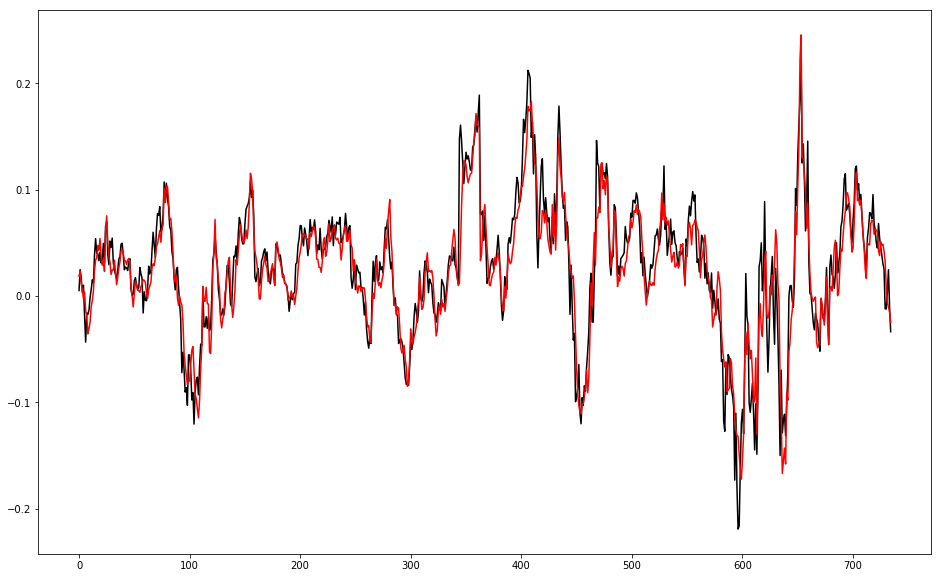

In [51]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(y_test, color="black")
ax.plot(predictions, color="red")
plt.show()

In [52]:
print("R2 Score:", metrics.r2_score(predictions, y_test))
print("Baseline:", baseline)

R2 Score: 0.8408702501223175
Baseline: 0.8478560562075556


### Plot trendlines for longterm predictions

In [54]:
# Inference: predict next 20 timesteps
prediction_length = 50
predictions = test(model, x_test, prediction_length)

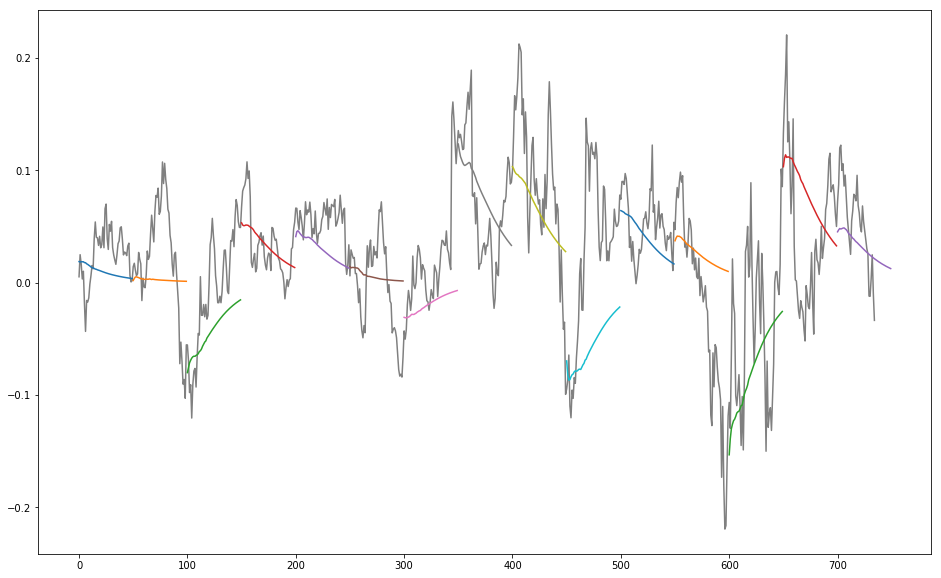

In [55]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(y_test, color="gray")
for i, prediction in enumerate(predictions):
    padding = [None for p in range(i * prediction_length)]
    plt.plot(padding + prediction)
plt.show()

## Stacked LSTM

In [56]:
# Create Stacked LSTM: 3 LSTM layers plus output layer
class StackedLSTM(gluon.nn.HybridBlock):
    
    def __init__(self, **kwargs):
        
        super(StackedLSTM, self).__init__(**kwargs)
        
        with self.name_scope():
            # NTC = data in the format of batch, time, channel
            self.lstm = gluon.nn.HybridSequential()#rnn.HybridSequentialRNNCell()
            self.lstm.add(gluon.rnn.LSTM(100, layout="NTC", dropout=0.2))
            self.lstm.add(gluon.rnn.LSTM(100, layout="NTC"))       
            self.lstm.add(gluon.rnn.LSTM(100, layout="NTC", dropout=0.2))
            
            # prediction layer
            self.dense = gluon.nn.Dense(1)
            
    # forward takes input and LSTM state vector        
    def hybrid_forward(self, F, x):
        x = self.lstm(x)
        x = self.dense(x)
        
        #return prediction and state vector
        return x

### Train and plot inference results


In [57]:
# Create model
model= StackedLSTM()
model.hybridize()

# load pretrained model
model.load_parameters("data/stackedLSTM.params", ctx=ctx)
# Loss
l2loss = gluon.loss.L2Loss()

# Trainer
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-4})

#Training Loop
#train(model, train_dataloader)


In [58]:
predictions = test(model, x_test, prediction_length=1)

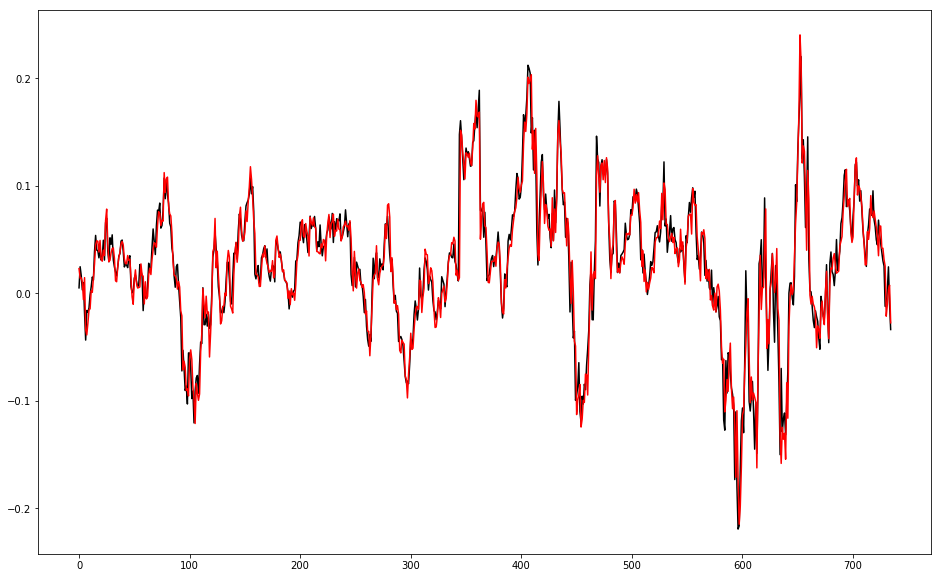

In [59]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(y_test, color="black")
ax.plot(predictions, color="red")
plt.show()

In [60]:
print("R2 Score:", metrics.r2_score(predictions, y_test))
print("Baseline", baseline)

R2 Score: 0.9192619067746224
Baseline 0.8478560562075556


In [61]:
prediction_length = 50 
predictions = test(model, x_test, prediction_length)

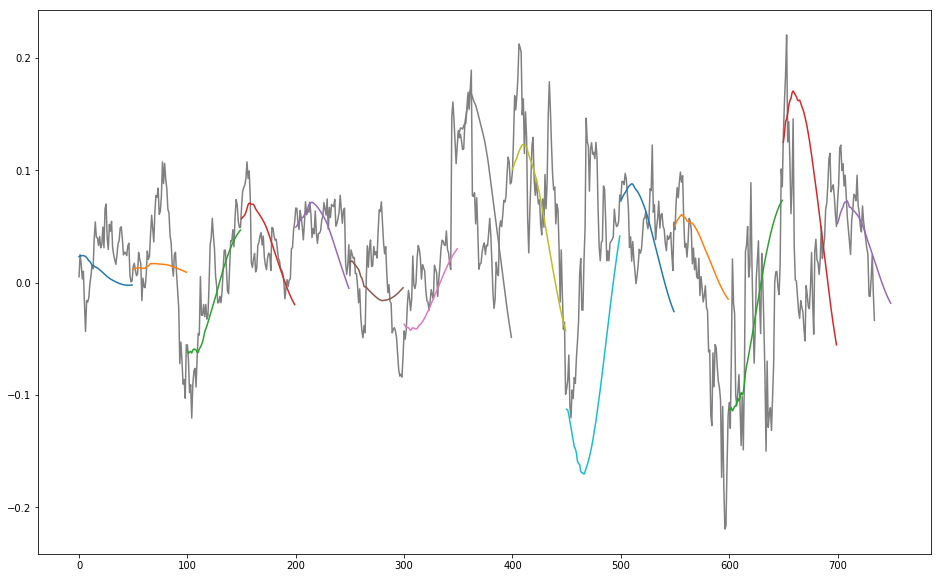

In [62]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(y_test, color="gray")

for i, prediction in enumerate(predictions):
    padding = [None for p in range(i * prediction_length)]
    plt.plot(padding + prediction)
plt.show()

### LSTNet

![](https://raw.githubusercontent.com/opringle/multivariate_time_series_forecasting/master/docs/model_architecture.png)
*Taken from https://arxiv.org/pdf/1703.07015.pdf*

In [63]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, gluon
from mxnet.gluon import nn, rnn

In [64]:
class LSTNet(gluon.HybridBlock):

    def __init__(self, num_series, conv_hid, gru_hid, skip_gru_hid, skip, ar_window, data_window):
        super(LSTNet, self).__init__()
        dropout_rate = 0.2
        self.skip = skip
        self.kernel_size = 6
        self.num_series = num_series
        self.ar_window = ar_window
        self.conv_output_shape = data_window - (self.kernel_size - 1)
        self.channels_rounded_to_skip_count = self.conv_output_shape // self.skip * self.skip
        self.skip_by_c_dims = skip_gru_hid * self.skip

        with self.name_scope():
            self.conv = nn.Conv1D(conv_hid, kernel_size=self.kernel_size, layout='NCW', activation='relu')
            self.dropout = nn.Dropout(dropout_rate)
            self.gru = rnn.GRU(gru_hid, layout='TNC')
            self.skip_gru = rnn.GRU(skip_gru_hid, layout='TNC')
            self.fc = nn.Dense(num_series)
            self.ar_fc = nn.Dense(1)

    def hybrid_forward(self, F, x, *args, **kwargs):
   
        # Convolution
        c = self.conv(x.transpose((0, 2, 1)))
        c = self.dropout(c)

        # GRU
        r = self.gru(c.transpose((2, 0, 1)))  
        r = r.slice_axis(axis=0, begin=-1, end=None).squeeze(axis=0)  
        r = self.dropout(r) 

        # Skip GRU
        skip_c = c.slice_axis(axis=2, begin=-self.channels_rounded_to_skip_count, end=None)
        skip_c = skip_c.reshape((0, 0, -4, -1, self.skip))
        skip_c = skip_c.transpose((2, 0, 3, 1))
        skip_c = skip_c.reshape((0, -3, -1))
        s = self.skip_gru(skip_c)
        s = s.slice_axis(axis=0, begin=-1, end=None).squeeze(axis=0)
        s = s.reshape((-1, self.skip_by_c_dims))

        # FC layer
        fc = self.fc(F.concat(r, s))  # NC layout

        # Autoregressive highway
        ar_x = x.slice_axis(axis=1, begin=-self.ar_window,  end=None)  
        ar_x = ar_x.transpose((0, 2, 1))  
        ar_x = ar_x.reshape((-3, -1))  
        ar = self.ar_fc(ar_x)
        ar = ar.reshape((-1, self.num_series))  

        # Add autoregressive and fc outputs
        res = fc + ar
        return res

In [65]:
def create_normalized_data(data, sequence_length, horizon=24):
    
    # number of time series values
    n_samples = data.shape[0] 
    
    # number of time series
    columns = data.shape[-1]
    
    # create empty matrices n_samples x sequence_length x 1
    x = np.zeros((n_samples - sequence_length, sequence_length , columns), dtype=np.float32)
    y = np.zeros((n_samples - sequence_length, columns), dtype=np.float32)
    
    # create normalized sequences
    for i in range(0, n_samples - sequence_length): 
        
        #iterate over features
        for col in range(columns):
            
            # get window
            window = data[i : i + sequence_length + horizon,:] 

            # normalize
            normalized = [((float(p) / float(window[0,col])) - 1) for p in window[:,col]]    
            
            # assign 
            x[i,:,col]   = normalized[:sequence_length]
            y[i,col]     = normalized[-1]
             
    return x, y

In [66]:
# how many past time steps to consider
sequence_length = 168

# batch size
batch_size = 128

# get data
df = pd.read_csv('data/AMZN.csv')
data = df[["Close","Volume"]].values

# split train/test
n = int(data.shape[0] * 0.85)


# get normalized train and test dataset 
x_train, y_train = create_normalized_data(data[:n,:], sequence_length)
x_test, y_test   = create_normalized_data(data[n:,:], sequence_length)

# create Dataloader
dataset = gluon.data.ArrayDataset(x_train, y_train)
train_dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch="rollover", shuffle=True)

In [67]:
# Create LSTNet model
model = LSTNet(num_series=2, conv_hid=100, gru_hid=100, skip_gru_hid=5, skip=24, ar_window=24, data_window=168)

model.initialize()
model.load_parameters("data/lstnet.params")
model.hybridize(static_alloc=True, static_shape=True)

# Loss
l2loss = gluon.loss.L2Loss()

# Trainer
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 1e-3})

# create Dataloader
dataset = gluon.data.ArrayDataset(x_train, y_train)
train_dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size, last_batch="rollover", shuffle=True)

#Training Loop
train(model, train_dataloader)


epoch [1/5], loss:0.0089920
epoch [2/5], loss:0.0092070
epoch [3/5], loss:0.0087285
epoch [4/5], loss:0.0098567
epoch [5/5], loss:0.0090331



<img src="data/lstnet.gif" alt="drawing" width="1200"/>

In [69]:
prediction_sequences = []
for i in range(0, x_test.shape[0]):

    # Batchify
    sequence = mx.nd.expand_dims(mx.nd.array(x_test[i,:,:]), axis=0)

    # Load data on GPU
    sequence = sequence.as_in_context(ctx)

    # Predict
    predicted = model(sequence)

    #Store
    prediction_sequences.append(predicted[0,0].asscalar())

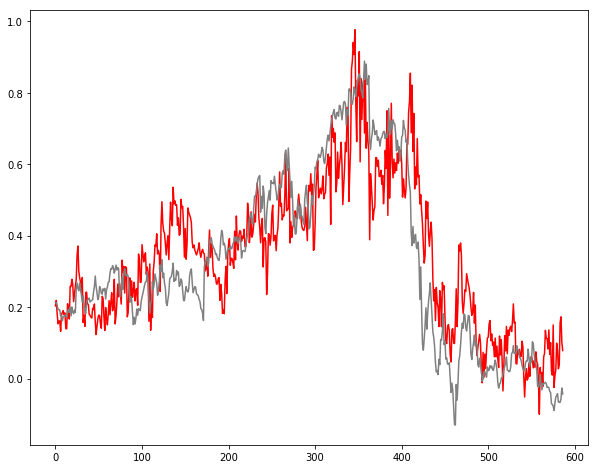

In [70]:
# Plot
fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(111)
ax.plot(prediction_sequences, color="red")
ax.plot(y_test[:,0], color="gray")
plt.show() 

In [71]:
print("R2 Score:", metrics.r2_score(prediction_sequences, y_test[:,0]))
print("Baseline", baseline25)

R2 Score: 0.6412664957308398
Baseline -0.09771242655583778


### DeepAR

- SageMaker builtin algorithm
- forecasting algorithm using RNNs
- Part of Gluon-TS toolkit https://github.com/awslabs/gluon-ts

![](https://docs.aws.amazon.com/sagemaker/latest/dg/images/ts-full-159.sampled.png)